# 函数说明
LogisticRegression(tol=0.0001, fit_intercept=True,class_weight=None, max_iter=100)  
tol:用于指定模型跌倒收敛的阈值   
fit_intercept:bool类型参数，是否拟合模型的截距项，默认为True   
class_weight:用于指定因变量类别的权重，如果为字典，则通过字典的形式{class_label:weight}传递每个类别的权重;如果为字符串'balanced'，则每个分类的权重与实际样本中的比例成反比，当各分类存在严重不平衡时，设置为'balanced'会比较好;如果为None，则表示每个分类的权重相等    max_iter:指定模型求解过程中的最大迭代次数， 默认为100 

In [1]:
import matplotlib.pyplot as plt
# 自定义绘制KS曲线函数
def plot_ks(y_test, y_score, positive_flag):
    #对y_test重新设置索引
    y_test.index = np.arange(len(y_test))
    #构建目标数据集
    target_data = pd.DataFrame({'y_test':y_test, 'y_score':y_score})
    #按y_score降序排列
    target_data.sort_values(by='y_score', ascending=False, inplace=True)
    #自定义分位点
    cuts = np.arange(0.1,1,0.1)
    #计算各分位点对应的score值
    index = len(target_data.y_score)*cuts
    scores = np.array(target_data.y_score)[index.astype('int')]
    #根据不同的score值，计算sensitivity和specificity
    Sensitivity = []
    Specificity = []
    for score in scores:
        #正例覆盖样本数量与实际正例样本数量
        positive_recall = target_data.loc[(target_data.y_test == positive_flag) & (target_data.y_score>score),:].shape[0]
        positive = sum(target_data.y_test == positive_flag)
        #负例覆盖样本与实际负例样本量
        negative_recall = target_data.loc[(target_data.y_test != positive_flag) & (target_data.y_score<=score),:].shape[0]
        negative = sum(target_data.y_test != positive_flag)
        
        Sensitivity.append(positive_recall/positive)
        Specificity.append(negative_recall/negative)
    #构建绘图数据
    plot_data = pd.DataFrame({'cuts':cuts,'y1':1-np.array(Specificity),'y2':np.array(Sensitivity),
                             'ks':np.array(Sensitivity)-(1-np.array(Specificity))})
    #寻找Sensitivity和1-Specficity之差的最大索引值
    max_ks_index = np.argmax(plot_data.ks)
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y1.tolist()+[1], label='1-Specificity')
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y2.tolist()+[1], label='Sensitivity')
    #添加参考线
    plt.vlines(plot_data.cuts[max_ks_index], ymin = plot_data.y1[max_ks_index],
              ymax = plot_data.y2[max_ks_index], linestyles='--')
    #显示图例
    plt.legend()
    #显示图形
    plt.show()

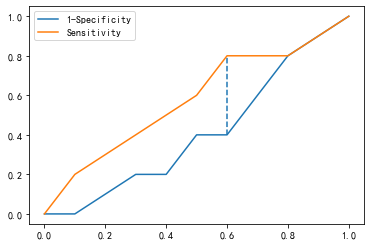

In [5]:
import pandas as pd
# 导入虚拟数据
virtua_data = pd.read_excel(r'/Users/jiabaohuang/python/data/virtual_data.xlsx')
# 应用自定义函数绘制k-s曲线
plot_ks(y_test=virtua_data.Class, y_score=virtua_data.Score, positive_flag='P')

In [4]:
# 导入第三方模块
from sklearn import model_selection
import numpy as np
from sklearn import linear_model
# 读取数据
sports = pd.read_csv(r'/Users/jiabaohuang/python/data/Run or Walk.csv')
# 提取所有自变量名称
predictors = sports.columns[4:]
# 构建自变量矩阵
# X = sports.ix[:, predictors]   #pandas版本更新，只适用于0.20.0之前
X = sports.iloc[:, 4:]
# 提取y变量值
y = sports.activity
# 拆分训练集测试集
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, random_state=1234 )
# 利用训练集建模
sklearn_logistic = linear_model.LogisticRegression() 
sklearn_logistic.fit(X_train, y_train)
# 返回模型的各个参数
print(sklearn_logistic.intercept_, sklearn_logistic.coef_)

[4.36637441] [[ 0.48695898  6.87517973 -2.44872468 -0.01385936 -0.16085022  0.13389695]]


In [6]:
# 模型预测
sklearn_predict = sklearn_logistic.predict(X_test)
# 预测结果统计
pd.Series(sklearn_predict).value_counts()

0    12119
1    10028
dtype: int64

In [7]:
# 导入包
from sklearn import metrics
# 混淆矩阵
cm = metrics.confusion_matrix(y_test, sklearn_predict, labels = [0,1])
cm

array([[9969, 1122],
       [2150, 8906]])

In [8]:
Accuracy = metrics.accuracy_score(y_test, sklearn_predict)
Sensitivity = metrics.recall_score(y_test, sklearn_predict)
Specificity = metrics.recall_score(y_test, sklearn_predict, pos_label=0)
print('模型准确率:%.2f%%'%(Accuracy*100), '\n',
     '正例覆盖率:%.2f%%'%(Sensitivity*100), '\n',
     '负例覆盖率:%.2f%%'%(Specificity*100))

模型准确率:85.23% 
 正例覆盖率:80.55% 
 负例覆盖率:89.88%


In [9]:
# 混淆矩阵可视化
# 导入包
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib
# 绘制热力图
sns.heatmap(cm, annot=True, fmt='.2e', cmap='GnBu')
plt.show()

Using matplotlib backend: MacOSX


In [12]:
# y得分为模型预测正例的概率
y_score = sklearn_logistic.predict_proba(X_test)[:,1]  
# 计算不同阈值之下，fpr和tpr的组合（fpr：1-Specificity，tpr：Sensitivity）
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
# 计算AUC
roc_AUC = metrics.auc(fpr, tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, colors='crimson', alpha=0.5, edgecolor='black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw=1)
# 添加对角线
plt.plot([0,1], [0,1], color='black', linestyle='--')
# 添加文本信息
plt.text(0.5, 0.3, 'ROC curve (area=%.2f)' %roc_AUC)
# 添加xy轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.show()

In [13]:
# 绘制KS曲线
plot_ks(y_test=y_test, y_score=y_score, positive_flag=1)

# statsmodels包计算

In [17]:
# -----建模-----
import statsmodels.api as sm
# 拆分训练集和测试集
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=1234)
# 为X的训练集和测试集添加常数列1
x_test2 = sm.add_constant(x_test)
x_train2 = sm.add_constant(x_train)
# 拟合logistic模型
sm_logistic = sm.Logit(y_train,x_train2).fit()
# 返回模型参数
sm_logistic.params

Optimization terminated successfully.
         Current function value: 0.324875
         Iterations 8


const             4.388537
acceleration_x    0.489617
acceleration_y    6.906590
acceleration_z   -2.459638
gyro_x           -0.014715
gyro_y           -0.161164
gyro_z            0.134655
dtype: float64

In [18]:
# -------预测并生成混淆矩阵-------
# 在测试集上预测
sm_y_prob = sm_logistic.predict(x_test2)
# 根据概率值，观测进行分类，以0.5为阀值
sm_pred_y = np.where(sm_y_prob >= .5, 1, 0)
# 混淆矩阵
cm2 = metrics.confusion_matrix(y_test, sm_pred_y, labels=[0,1])
cm2

array([[9967, 1124],
       [2149, 8907]])

In [19]:
# -------绘制ROC曲线-------
# 计算fpr和tpr
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test, sm_y_prob)
# 计算AUC
roc_AUC2 = metrics.auc(fpr, tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha=1, edgecolor='black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw=0.5)
# 添加对角线
plt.plot([0,1],[0,1], color='crimson', linestyle='--')
# 添加文本信息
plt.text(.5, .3, 'ROC curve (area = %.2f)' % roc_AUC2)
# 添加xy轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.show()

In [20]:
# --------绘制K-S曲线-----------
# 调用自定义函数
sm_y_prob.index = np.arange(len(sm_y_prob))
plot_ks(y_test=y_test, y_score=sm_y_prob, positive_flag=1)